In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= "test.p"
testing_file = "valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
import pandas as pd
import numpy as np

In [3]:
#converting to numpy arrays

xtrain = np.array(X_train)
ytrain = np.array(y_train)
xvalid = np.array(X_valid)
yvalid = np.array(y_valid)
xtest = np.array(X_test)
ytest = np.array(y_test)



np.shape(xtrain)

(34799, 32, 32, 3)

In [4]:
# TODO: Number of training examples
n_train = np.shape(ytrain)[0]

# TODO: Number of validation examples
n_validation = np.shape(yvalid)[0]

# TODO: Number of testing examples.
n_test = np.shape(ytest)[0]

# TODO: What's the shape of an traffic sign image?
image_shape = 32 * 32

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 4410
Image data shape = 1024
Number of classes = 43


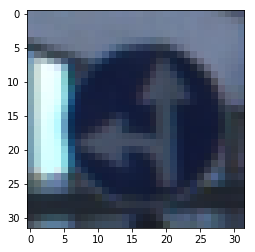

In [5]:
#visualizing data samples

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

imgplot = plt.imshow(xtrain[5000])

In [6]:
#preprocessing functions

def normalize(x):
    return (x.astype(float) - 128) / 128

In [7]:
#preprocessing data

xtrain_norm = normalize(xtrain)
xtest_norm = normalize(xtest)
xvalid_norm = normalize(xvalid)

xtrain_norm = xtrain_norm.transpose((0, 3, 1, 2))
xtest_norm = xtest_norm.transpose((0, 3, 1, 2))
xvalid_norm = xvalid_norm.transpose((0, 3, 1, 2))
#np.shape(xtrain_norm)

In [8]:
#imports

from __future__ import print_function, division
import os
import torch
import torch.nn as nn
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [9]:
#converting to tensors

xtrainTensor = torch.from_numpy(xtrain_norm)
xtestTensor = torch.from_numpy(xtest_norm)
xvalidTensor = torch.from_numpy(xvalid_norm)

ytrainTensor = torch.from_numpy(ytrain).long()
ytestTensor = torch.from_numpy(ytest).long()
yvalidTensor = torch.from_numpy(yvalid).long()


In [10]:
import torch.utils.data as utils

#creating tensor datasets
train_dataset = utils.TensorDataset(xtrainTensor, ytrainTensor) # create your datset
test_dataset = utils.TensorDataset(xtestTensor, ytestTensor)
valid_dataset = utils.TensorDataset(xvalidTensor, yvalidTensor)


In [11]:
#creating loaders

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [12]:
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

8

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Convolution 1
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 1, padding = 2)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(16)
        
        #maxpool1
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        
        #convolution2
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(32)
        
        #maxpool2
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        
        #FC layer
        self.fc1 = nn.Linear(32*8*8, 32*8*8)
        
        #relu3
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(32*8*8, 43)
        
    def forward(self, x):
        #cnn1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.norm1(out)
        
        #maxpool1
        out = self.maxpool1(out)
        m = nn.Dropout2d(p=0.2)
        out = m(out)
        
        #cnn2
        out = self.cnn2(out)    
        out = self.relu2(out)
        out = self.norm2(out)
        
        #maxpool2
        out = self.maxpool2(out)
        m = nn.Dropout2d(p=0.2)
        out = m(out)
        
        #resize 
        out = out.view(out.size(0), -1)
        
        #linear function (readout)
        out = self.fc1(out)
        
        out = self.relu3(out)
        out = self.fc2(out)
        return out
        

In [14]:
model = CNN()
model = model.double()

if torch.cuda.is_available:
    model.cuda() #Model on GPU

In [15]:
criterion = nn.CrossEntropyLoss()

In [25]:
learning_rate = 0.001
moment = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = moment, nesterov = True)

In [ ]:
#training method 1

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        optimizer.zero_grad()
        
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                if torch.cuda.is_available:
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted.cpu() == labels.cpu()).sum()
                
            accuracy = 100 * correct / total
            print('Epoch: {}. Iteration: {}. Loss: {}. Accuracy:{}'.format(epoch, iter, loss.data[0], accuracy))
            
        

In [26]:
#Training method 2

losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.float())
            labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch : 1/8, Iter : 100/347,  Loss: 0.0124
Epoch : 1/8, Iter : 200/347,  Loss: 0.1059
Epoch : 1/8, Iter : 300/347,  Loss: 0.0216
Epoch : 2/8, Iter : 100/347,  Loss: 0.0159
Epoch : 2/8, Iter : 200/347,  Loss: 0.0235
Epoch : 2/8, Iter : 300/347,  Loss: 0.1886
Epoch : 3/8, Iter : 100/347,  Loss: 0.0446
Epoch : 3/8, Iter : 200/347,  Loss: 0.0166
Epoch : 3/8, Iter : 300/347,  Loss: 0.0107
Epoch : 4/8, Iter : 100/347,  Loss: 0.0193
Epoch : 4/8, Iter : 200/347,  Loss: 0.0135
Epoch : 4/8, Iter : 300/347,  Loss: 0.0487
Epoch : 5/8, Iter : 100/347,  Loss: 0.0481
Epoch : 5/8, Iter : 200/347,  Loss: 0.0282
Epoch : 5/8, Iter : 300/347,  Loss: 0.0189
Epoch : 6/8, Iter : 100/347,  Loss: 0.0826
Epoch : 6/8, Iter : 200/347,  Loss: 0.0543
Epoch : 6/8, Iter : 300/347,  Loss: 0.0366
Epoch : 7/8, Iter : 100/347,  Loss: 0.0097
Epoch : 7/8, Iter : 200/347,  Loss: 0.0811
Epoch : 7/8, Iter : 300/347,  Loss: 0.0060
Epoch : 8/8, Iter : 100/347,  Loss: 0.0068
Epoch : 8/8, Iter : 200/347,  Loss: 0.0564
Epoch : 8/8

In [27]:
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.cuda())
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.cpu()).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.0000 %


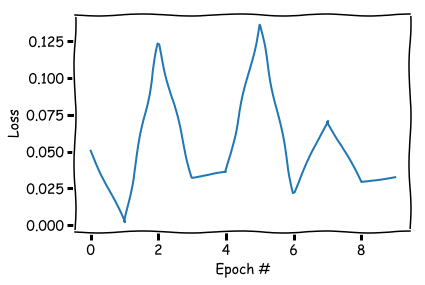

In [30]:
losses_in_epochs = losses[0::300]
plt.xkcd()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
plt.show()